In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nemak_raw = pd.read_excel('NEMAK_wybrane.xlsx')

In [3]:
clean_nemak_raw = nemak_raw.dropna(how='any')

In [4]:
clean_nemak_raw['status_value'] = clean_nemak_raw['Leakage_High'].apply(lambda x: 1 if x <=0.125 else 0)

C:\Users\patry\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [5]:
import random

class Status:
    GOOD = "GOOD"
    NO_GOOD = "NO GOOD"
    
    
class Leakage:
    def __init__(self,value ):
        self.value = value
        self.leakage_status = self.get_leakage_status()
        
    def get_leakage_status(self):
        if self.value<=0.125:
            return Status.GOOD
        else:
            return Status.NO_GOOD


class LeakageContainer:
    def __init__(self,inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs
        self.conected = self.connect()
        
        
    def connect(self):
        #return list(zip(self.inputs,self.outputs))
        #return inputs+outputs
        
        con_list = []
        for index in range (len(self.inputs)):
            con_list.append(self.inputs[index] + [self.outputs[index]] )
        return con_list
        
    def get_status(self):
        return [x.leakage_status for x in self.outputs]
    
    #def temp(self,x):
        #print(x)
        #return x[-1].leakage_status== Status.NO_GOOD
        
    
    def evenly_distribute(self):
        
        no_good = list(filter(lambda x: x[-1].leakage_status == Status.NO_GOOD ,self.conected))
        good= list(filter(lambda x: x[-1].leakage_status == Status.GOOD,self.conected))
        good_shrunk = good[:len(no_good)]
        self.conected = no_good+good_shrunk
        random.shuffle(self.conected)
        
        
        
        inputs=[]
        
        for x in self.conected:
            inputs.append(x[0:-1])
        
        
        outputs=[]
        
        for x in self.conected:
            outputs.append(x[-1])
        
        
        self.inputs = inputs
        self.outputs = outputs
        print(len(self.inputs))




In [6]:
nemak = clean_nemak_raw.drop(['Leakage_High','LeakageHighStatus','status_value'],axis=1).reset_index(drop=True)
output = clean_nemak_raw['status_value'].reset_index(drop=True)

# sieć neuronowa

In [7]:
nemak = nemak.to_numpy()

In [8]:
output=output.to_numpy()
print(type(output))
print(type(nemak))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
#dzielenie modelu
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(nemak, output, test_size=0.33,random_state=42) #random_state=42

In [10]:
import tensorflow as tf
from tensorflow import keras



model = keras.Sequential([
    keras.layers.Dense(48,input_shape=[48,],activation='relu'),
    keras.layers.Dense(4,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1,activation = 'sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [11]:
history=model.fit(X_train,y_train,batch_size=16,epochs=5)

Epoch 1/5
5341/5341 [==============================] - 3s 565us/step - loss: 0.1192 - accuracy: 0.9920
Epoch 2/5
5341/5341 [==============================] - 3s 549us/step - loss: 0.0394 - accuracy: 0.9943
Epoch 3/5
5341/5341 [==============================] - 3s 551us/step - loss: 0.0365 - accuracy: 0.9940
Epoch 4/5
5341/5341 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.99 - 3s 559us/step - loss: 0.0387 - accuracy: 0.9934
Epoch 5/5
5341/5341 [==============================] - 3s 592us/step - loss: 0.0361 - accuracy: 0.9939


In [12]:
#x = np.column_stack((train_X.nazwa_kolumny.valuse, train_X.nazwa_kolumny2.values))

# pomieszaj dane do nauki

In [13]:
#ewaluacja na test data

model.evaluate(X_test,y_test)

1316/1316 [==============================] - 1s 488us/step - loss: 0.0362 - accuracy: 0.9938


[0.03618727996945381, 0.9937516450881958]

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                2352      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 196       
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 2,553
Trainable params: 2,553
Non-trainable params: 0
_________________________________________________________________


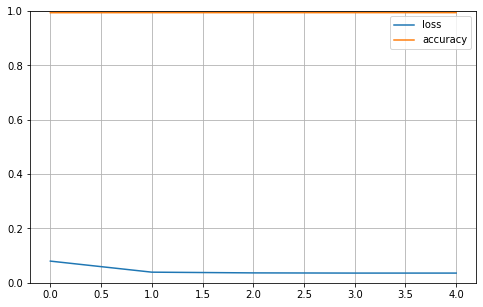

In [15]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

C:\Users\patry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4969423036214101
0.5


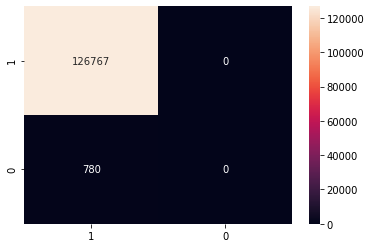

In [16]:
# na całych danych
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(nemak)
flat_list1 = []
flat_list = []
for sublist in y_pred1:
    for item in sublist:
        flat_list1.append(item)
        flat_list.append(round(item))
#y_test
print(precision_score(output, flat_list , average="macro"))
print(recall_score(output, flat_list , average="macro"))
f1_score(output,flat_list, average=None,labels=[1,0])

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

labels =[1,0]
labels2 =[0,1]
cm=confusion_matrix (output,flat_list , labels=labels)
df_cm = pd.DataFrame(cm,index=labels, columns=labels)

sn.heatmap(df_cm,annot=True,fmt='d')

In [17]:
#normalizacja wsadowa
import tensorflow as tf
from tensorflow import keras



model = keras.Sequential([
    keras.layers.Dense(48,input_shape=[48,],activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(4,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1,activation = 'sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [18]:
history=model.fit(X_train,y_train,batch_size=16,epochs=5)

Epoch 1/5
5341/5341 [==============================] - 5s 766us/step - loss: 0.1920 - accuracy: 0.9427
Epoch 2/5
5341/5341 [==============================] - 5s 871us/step - loss: 0.0332 - accuracy: 0.9941
Epoch 3/5
5341/5341 [==============================] - 5s 861us/step - loss: 0.0351 - accuracy: 0.9936
Epoch 4/5
5341/5341 [==============================] - 5s 857us/step - loss: 0.0328 - accuracy: 0.9942
Epoch 5/5
5341/5341 [==============================] - 5s 864us/step - loss: 0.0331 - accuracy: 0.9939


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 48)                2352      
_________________________________________________________________
batch_normalization (BatchNo (None, 48)                192       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 196       
_________________________________________________________________
batch_normalization_1 (Batch (None, 4)                 16        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,761
Trainable params: 2,657
Non-trainable params: 104
__________________________________________________

0.6016277282317819
0.5056351264676381


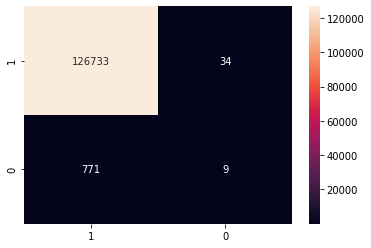

In [20]:
# na całych danych
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(nemak)
flat_list1 = []
flat_list = []
for sublist in y_pred1:
    for item in sublist:
        flat_list1.append(item)
        flat_list.append(round(item))
#y_test
print(precision_score(output, flat_list , average="macro"))
print(recall_score(output, flat_list , average="macro"))
f1_score(output,flat_list, average=None,labels=[1,0])

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

labels =[1,0]
labels2 =[0,1]
cm=confusion_matrix (output,flat_list , labels=labels)
df_cm = pd.DataFrame(cm,index=labels, columns=labels)

sn.heatmap(df_cm,annot=True,fmt='d')

# Zwiększenie ilości neuronów ukrytych

In [21]:
model = keras.Sequential([
    keras.layers.Dense(256,input_shape=[48,],activation='relu'),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(1,activation = 'sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [22]:
history=model.fit(X_train,y_train,batch_size=16,epochs=10)

Epoch 1/10
5341/5341 [==============================] - 11s 2ms/step - loss: 0.0512 - accuracy: 0.9901
Epoch 2/10
5341/5341 [==============================] - 15s 3ms/step - loss: 0.0389 - accuracy: 0.9941
Epoch 3/10
5341/5341 [==============================] - 13s 2ms/step - loss: 0.0368 - accuracy: 0.9941
Epoch 4/10
5341/5341 [==============================] - 12s 2ms/step - loss: 0.0345 - accuracy: 0.9944
Epoch 5/10
5341/5341 [==============================] - 11s 2ms/step - loss: 0.0359 - accuracy: 0.9939
Epoch 6/10
5341/5341 [==============================] - 18s 3ms/step - loss: 0.0365 - accuracy: 0.9941
Epoch 7/10
5341/5341 [==============================] - 16s 3ms/step - loss: 0.0357 - accuracy: 0.9943
Epoch 8/10
5341/5341 [==============================] - 22s 4ms/step - loss: 0.0372 - accuracy: 0.9936
Epoch 9/10
5341/5341 [==============================] - 21s 4ms/step - loss: 0.0348 - accuracy: 0.9943
Epoch 10/10
5341/5341 [==============================] - 19s 3ms/step - l

In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)
y_pred
#y_test
print(precision_score(y_test, y_pred , average="macro"))
print(recall_score(y_test, y_pred , average="macro"))
f1_score(y_test,y_pred, average=None,labels=[1,0])

0.003124183317098667
0.5


C:\Users\patry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.        , 0.01241913])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               12544     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)              

AttributeError: module 'matplotlib' has no attribute 'grid'

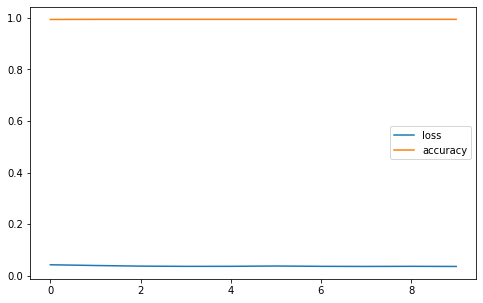

In [26]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

C:\Users\patry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4969423036214101
0.5


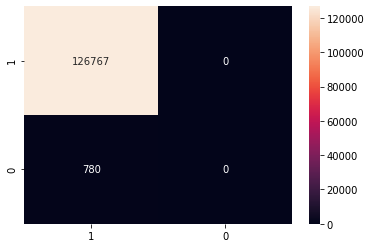

In [27]:
# na całych danych
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(nemak)
flat_list1 = []
flat_list = []
for sublist in y_pred1:
    for item in sublist:
        flat_list1.append(item)
        flat_list.append(round(item))
#y_test
print(precision_score(output, flat_list , average="macro"))
print(recall_score(output, flat_list , average="macro"))
f1_score(output,flat_list, average=None,labels=[1,0])

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

labels =[1,0]
labels2 =[0,1]
cm=confusion_matrix (output,flat_list , labels=labels)
df_cm = pd.DataFrame(cm,index=labels, columns=labels)

sn.heatmap(df_cm,annot=True,fmt='d')

In [28]:
model = keras.Sequential([
    keras.layers.Dense(512,input_shape=[48,],activation='relu'),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(1,activation = 'sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [29]:
history=model.fit(X_train,y_train,batch_size=32,epochs=20)

Epoch 1/20
2671/2671 [==============================] - 8s 3ms/step - loss: 0.0690 - accuracy: 0.9792
Epoch 2/20
2671/2671 [==============================] - 11s 4ms/step - loss: 0.0382 - accuracy: 0.9941
Epoch 3/20
2671/2671 [==============================] - 13s 5ms/step - loss: 0.0385 - accuracy: 0.9938
Epoch 4/20
2671/2671 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.99 - 14s 5ms/step - loss: 0.0376 - accuracy: 0.9939
Epoch 5/20
2671/2671 [==============================] - 13s 5ms/step - loss: 0.0353 - accuracy: 0.9942
Epoch 6/20
2671/2671 [==============================] - 13s 5ms/step - loss: 0.0370 - accuracy: 0.9937
Epoch 7/20
2671/2671 [==============================] - 13s 5ms/step - loss: 0.0359 - accuracy: 0.9939
Epoch 8/20
2671/2671 [==============================] - 13s 5ms/step - loss: 0.0342 - accuracy: 0.9942
Epoch 9/20
2671/2671 [==============================] - 13s 5ms/step - loss: 0.0351 - accuracy: 0.9939
Epoch 10/20
2671/2671 [=========

In [30]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)
y_pred
#y_test
print(precision_score(y_test, y_pred , average="macro"))
print(recall_score(y_test, y_pred , average="macro"))
f1_score(y_test,y_pred, average=None,labels=[1,0])


0.003124183317098667
0.5


C:\Users\patry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.        , 0.01241913])

In [31]:
# na całych danych
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(nemak)
flat_list1 = []
flat_list = []
for sublist in y_pred1:
    for item in sublist:
        flat_list1.append(item)
        flat_list.append(round(item))
#y_test
print(precision_score(output, flat_list , average="macro"))
print(recall_score(output, flat_list , average="macro"))
f1_score(output,flat_list, average=None,labels=[1,0])

0.49694227964812693
0.4999960557558355


array([0.99692898, 0.        ])

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               25088     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)              

AttributeError: module 'matplotlib' has no attribute 'grid'

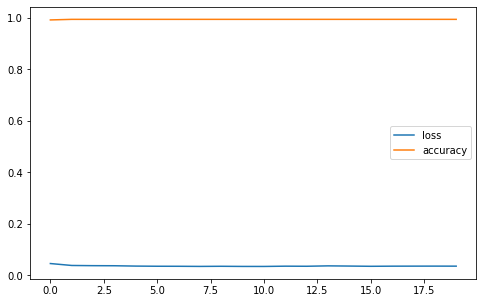

In [33]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

0.49694227964812693
0.4999960557558355


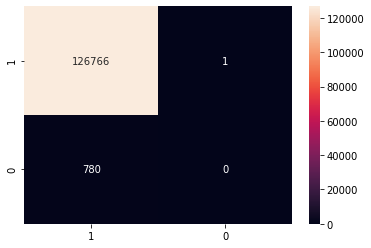

In [34]:
# na całych danych
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(nemak)
flat_list1 = []
flat_list = []
for sublist in y_pred1:
    for item in sublist:
        flat_list1.append(item)
        flat_list.append(round(item))
#y_test
print(precision_score(output, flat_list , average="macro"))
print(recall_score(output, flat_list , average="macro"))
f1_score(output,flat_list, average=None,labels=[1,0])

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

labels =[1,0]
labels2 =[0,1]
cm=confusion_matrix (output,flat_list , labels=labels)
df_cm = pd.DataFrame(cm,index=labels, columns=labels)

sn.heatmap(df_cm,annot=True,fmt='d')

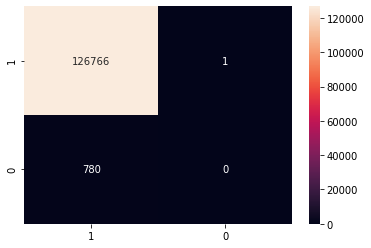

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

labels =[1,0]
labels2 =[0,1]
cm=confusion_matrix (output,flat_list , labels=labels)
df_cm = pd.DataFrame(cm,index=labels, columns=labels)

sn.heatmap(df_cm,annot=True,fmt='d')

In [36]:
data  = {'rzeczywisty':output,'predykcja':flat_list, 'wynik_przewidziany':flat_list1}
sprawdzenie = pd.DataFrame(data=data)



In [37]:
sprawdzenie


,rzeczywisty,predykcja,wynik_przewidziany
0,1,1,0.985231
1,1,1,0.988159
2,1,1,0.990722
3,1,1,0.989813
4,1,1,0.988530
...,...,...,...
127542,1,1,0.994322
127543,1,1,0.994336
127544,1,1,0.994225
127545,1,1,0.994482


In [38]:
sprawdzenie.to_excel("output.xlsx")

In [39]:
#zbalansowanie danych

In [40]:
class_weight = {
    0: 10.0,
    1: 1.0,
}
class_weight=class_weight

history = model.fit(X_train,y_train, class_weight=class_weight, batch_size=32, epochs=10)

Epoch 1/10
2671/2671 [==============================] - 11s 4ms/step - loss: 0.2263 - accuracy: 0.9940
Epoch 2/10
2671/2671 [==============================] - 12s 4ms/step - loss: 0.2177 - accuracy: 0.9940
Epoch 3/10
2671/2671 [==============================] - 11s 4ms/step - loss: 0.2211 - accuracy: 0.9938
Epoch 4/10
2671/2671 [==============================] - 15s 6ms/step - loss: 0.2132 - accuracy: 0.9939
Epoch 5/10
2671/2671 [==============================] - 15s 6ms/step - loss: 0.2178 - accuracy: 0.9940
Epoch 6/10
2671/2671 [==============================] - 21s 8ms/step - loss: 0.2154 - accuracy: 0.9940
Epoch 7/10
2671/2671 [==============================] - 19s 7ms/step - loss: 0.2146 - accuracy: 0.9940
Epoch 8/10
2671/2671 [==============================] - 16s 6ms/step - loss: 0.2212 - accuracy: 0.9940
Epoch 9/10
2671/2671 [==============================] - 15s 6ms/step - loss: 0.2262 - accuracy: 0.9940
Epoch 10/10
2671/2671 [==============================] - 13s 5ms/step - l

AttributeError: module 'matplotlib' has no attribute 'grid'

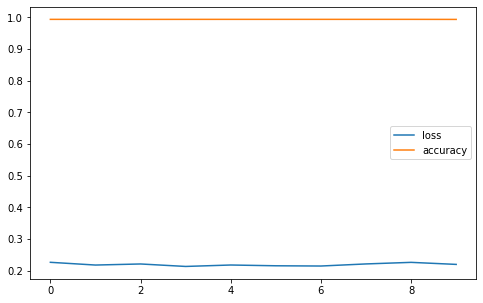

In [41]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

C:\Users\patry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.4969423036214101
0.5


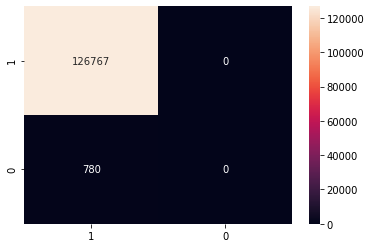

In [42]:
# na całych danych
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(nemak)
flat_list1 = []
flat_list = []
for sublist in y_pred1:
    for item in sublist:
        flat_list1.append(item)
        flat_list.append(round(item))
#y_test
print(precision_score(output, flat_list , average="macro"))
print(recall_score(output, flat_list , average="macro"))
f1_score(output,flat_list, average=None,labels=[1,0])

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

labels =[1,0]
labels2 =[0,1]
cm=confusion_matrix (output,flat_list , labels=labels)
df_cm = pd.DataFrame(cm,index=labels, columns=labels)

sn.heatmap(df_cm,annot=True,fmt='d')

# SMOTE



In [43]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)



X_sm, y_sm = sm.fit_resample(X_train,y_train)

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X_sm,y_sm, test_size=0.33,random_state=42)

In [45]:
model = keras.Sequential([
    keras.layers.Dense(512,input_shape=[48,],activation='relu'),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(1,activation = 'sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [46]:
history=model.fit(X_train,y_train,batch_size=16,epochs=40)

Epoch 1/40
7114/7114 [==============================] - 21s 3ms/step - loss: 0.6016 - accuracy: 0.6924
Epoch 2/40
7114/7114 [==============================] - 27s 4ms/step - loss: 0.5023 - accuracy: 0.7482
Epoch 3/40
7114/7114 [==============================] - 23s 3ms/step - loss: 0.4768 - accuracy: 0.7596
Epoch 4/40
7114/7114 [==============================] - 22s 3ms/step - loss: 0.4696 - accuracy: 0.7631
Epoch 5/40
7114/7114 [==============================] - 20s 3ms/step - loss: 0.4595 - accuracy: 0.7696
Epoch 6/40
7114/7114 [==============================] - 20s 3ms/step - loss: 0.4475 - accuracy: 0.7791
Epoch 7/40
7114/7114 [==============================] - 27s 4ms/step - loss: 0.4404 - accuracy: 0.7847
Epoch 8/40
7114/7114 [==============================] - 27s 4ms/step - loss: 0.4332 - accuracy: 0.7871
Epoch 9/40
7114/7114 [==============================] - 46s 6ms/step - loss: 0.4269 - accuracy: 0.7919
Epoch 10/40
7114/7114 [==============================] - 40s 6ms/step - l

In [57]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)
y_pred
#y_test
print(precision_score(y_test, y_pred , average="macro"))
print(recall_score(y_test, y_pred , average="macro"))
f1_score(y_test,y_pred, average=None,labels=[1,0])

0.25037459864430966
0.5


C:\Users\patry\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.        , 0.66733229])

0.8465775691526987
0.8442670978601626


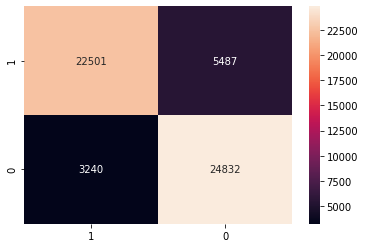

In [58]:
# na danych SOMA
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(X_test)
flat_list1 = []
flat_list = []
for sublist in y_pred1:
    for item in sublist:
        flat_list1.append(item)
        flat_list.append(round(item))
#y_test
print(precision_score(y_test, flat_list , average="macro"))
print(recall_score(y_test, flat_list , average="macro"))
f1_score(y_test,flat_list, average=None,labels=[1,0])

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

labels =[1,0]
labels2 =[0,1]
cm=confusion_matrix (y_test,flat_list , labels=labels)
df_cm = pd.DataFrame(cm,index=labels, columns=labels)

sn.heatmap(df_cm,annot=True,fmt='d')

In [48]:
# na całych danych
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(nemak)
flat_list1 = []
flat_list = []
for sublist in y_pred1:
    for item in sublist:
        flat_list1.append(item)
        flat_list.append(round(item))
#y_test
print(precision_score(output, flat_list , average="macro"))
print(recall_score(output, flat_list , average="macro"))
f1_score(output,flat_list, average=None,labels=[1,0])

0.5109595272925693
0.7892459626615598


array([0.88996445, 0.0458733 ])

In [49]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               25088     
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)              

AttributeError: module 'matplotlib' has no attribute 'grid'

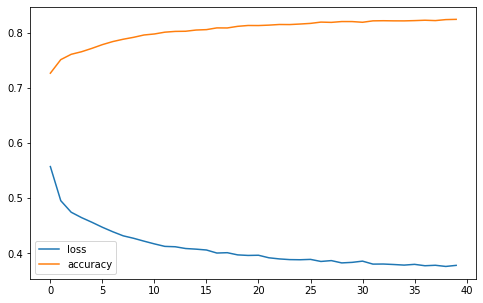

In [50]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [51]:
data  = {'rzeczywisty':output,'predykcja':flat_list, 'wynik_przewidziany':flat_list1}
sprawdzenies = pd.DataFrame(data=data)

In [52]:
sprawdzenies

,rzeczywisty,predykcja,wynik_przewidziany
0,1,1,0.999962
1,1,1,0.998773
2,1,1,0.999887
3,1,1,0.999968
4,1,1,0.999971
...,...,...,...
127542,1,1,0.999983
127543,1,1,0.999992
127544,1,1,0.999979
127545,1,1,0.999971


In [53]:
sprawdzenies.to_excel("outputs.xlsx")

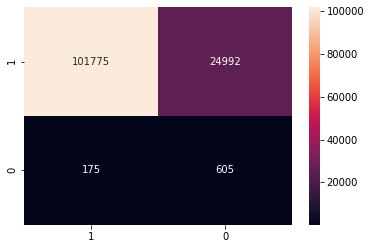

In [54]:


from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

labels =[1,0]
labels2 =[0,1]
cm=confusion_matrix (output,flat_list , labels=labels)
df_cm = pd.DataFrame(cm,index=labels, columns=labels)

sn.heatmap(df_cm,annot=True,fmt='d')

# dodanie classweight

In [73]:
model = keras.Sequential([
    keras.layers.Dense(512,input_shape=[48,],activation='relu'),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(1,activation = 'sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
class_weight = {
    0: 10.0,
    1: 1.0,
}
class_weight=class_weight

In [74]:


history = model.fit(X_train,y_train, class_weight=class_weight, batch_size=16, epochs=120)

Epoch 1/120
7114/7114 [==============================] - 23s 3ms/step - loss: 1.5571 - accuracy: 0.5088
Epoch 2/120
7114/7114 [==============================] - 24s 3ms/step - loss: 1.2764 - accuracy: 0.6102
Epoch 3/120
7114/7114 [==============================] - 26s 4ms/step - loss: 1.2114 - accuracy: 0.6267
Epoch 4/120
7114/7114 [==============================] - 26s 4ms/step - loss: 1.1808 - accuracy: 0.6434
Epoch 5/120
7114/7114 [==============================] - 22s 3ms/step - loss: 1.1516 - accuracy: 0.6538
Epoch 6/120
7114/7114 [==============================] - 20s 3ms/step - loss: 1.1197 - accuracy: 0.6655
Epoch 7/120
7114/7114 [==============================] - 21s 3ms/step - loss: 1.1207 - accuracy: 0.6629
Epoch 8/120
7114/7114 [==============================] - 21s 3ms/step - loss: 1.1169 - accuracy: 0.6680
Epoch 9/120
7114/7114 [==============================] - 21s 3ms/step - loss: 1.0944 - accuracy: 0.6754
Epoch 10/120
7114/7114 [==============================] - 25s 4m

AttributeError: module 'matplotlib' has no attribute 'grid'

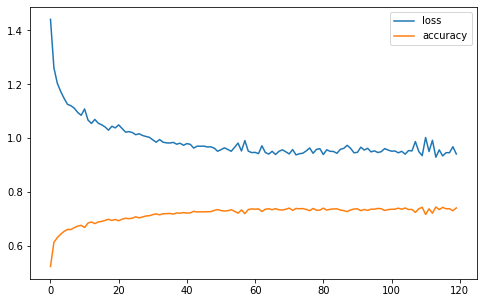

In [75]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

0.5054965975706485
0.7260765207640183


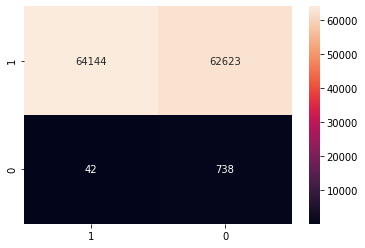

In [76]:
# na całych danych
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(nemak)
flat_list1 = []
flat_list = []
for sublist in y_pred1:
    for item in sublist:
        flat_list1.append(item)
        flat_list.append(round(item))
#y_test
print(precision_score(output, flat_list , average="macro"))
print(recall_score(output, flat_list , average="macro"))
f1_score(output,flat_list, average=None,labels=[1,0])

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

labels =[1,0]
labels2 =[0,1]
cm=confusion_matrix (output,flat_list , labels=labels)
df_cm = pd.DataFrame(cm,index=labels, columns=labels)

sn.heatmap(df_cm,annot=True,fmt='d')